<a href="https://colab.research.google.com/github/oxzoid/topsis-for-pretrained-models/blob/main/topsis_on_pretrained_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5fbb88ba4a72d2db743e8cdf5b6d34085494ec1b32463b9462b6e8d4e2dfe7e2
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Final Ranking of Text Conversational Models:
                                  BLEU   ROUGE-1   ROUGE-2   ROUGE-L  \
microsoft/DialoGPT-small           0.0  0.884615  0.870707  0.884615   
google/flan-t5-small               0.0  0.211960  0.042105  0.191960   
facebook/blenderbot-400M-distill   0.0  0.134559  0.000000  0.134559   
EleutherAI/gpt-neo-125M            0.0  0.251527  0.212662  0.251527   
bigscience/bloom-560m              0.0  0.224029  0.186909  0.224029   

                                  Response Length  TOPSIS Score  Rank  
microsoft/DialoGPT-small                      6.6      1.000000   1.0  
google/flan-t5-small                         12.6      0.341985   2.0  
facebook/blenderbot-400M-distill             15.4      0.298268   3.0  
EleutherAI/gpt-neo-125M                      34.6      0.188211   4.0  
bigscience/bloom-560m                        41.0      0.132989   5.0  


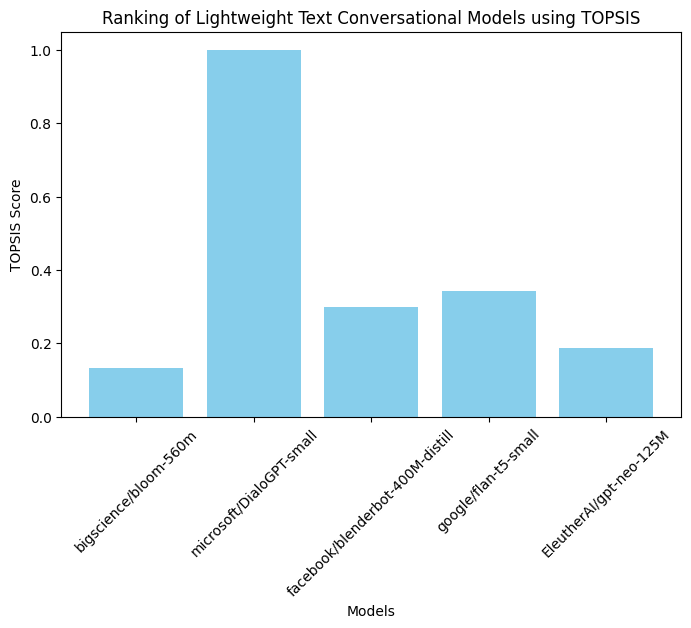

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Define lightweight conversational models to avoid RAM issues
models = [
    "bigscience/bloom-560m",
    "microsoft/DialoGPT-small",
    "facebook/blenderbot-400M-distill",
    "google/flan-t5-small",
    "EleutherAI/gpt-neo-125M"
]

# Predefined prompts
prompts = [
    "What is the future of AI?",
    "Tell me a fun science fact.",
    "How does a black hole form?",
    "Who invented electricity?",
    "Give me a productivity tip."
]

# Placeholder for storing results
results_dict = {}

def calculate_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu(references, candidates, smoothing_function=smoothie)

def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = scorer.score(references, candidate)
    return scores["rouge1"].fmeasure, scores["rouge2"].fmeasure, scores["rougeL"].fmeasure

# Evaluate models
for model_name in models:
    bleu_scores, rouge1_scores, rouge2_scores, rougeL_scores, response_lengths = [], [], [], [], []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    try:
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    except:
        model = AutoModelForCausalLM.from_pretrained(model_name)

    input_ids = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)["input_ids"]
    with torch.no_grad():
        output = model.generate(input_ids=input_ids, max_length=50)

    generated_responses = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    for prompt, generated_response in zip(prompts, generated_responses):
        bleu_score = calculate_bleu([[prompt]], [[generated_response]])
        rouge1, rouge2, rougeL = calculate_rouge(prompt, generated_response)

        bleu_scores.append(bleu_score)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)
        response_lengths.append(len(generated_response.split()))

    results_dict[model_name] = {
        "BLEU": np.mean(bleu_scores),
        "ROUGE-1": np.mean(rouge1_scores),
        "ROUGE-2": np.mean(rouge2_scores),
        "ROUGE-L": np.mean(rougeL_scores),
        "Response Length": np.mean(response_lengths)
    }

# Convert to DataFrame
df = pd.DataFrame.from_dict(results_dict, orient="index")

# Normalize the metrics
df_normalized = pd.DataFrame(MinMaxScaler().fit_transform(df), index=df.index, columns=df.columns)
df_normalized["Response Length"] = 1 - df_normalized["Response Length"]  # Invert Response Length since shorter is often better

# Define equal metric weights
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
weighted_df = df_normalized * weights

# Compute Ideal Best and Worst Values
ideal_best = weighted_df.max()
ideal_worst = weighted_df.min()

# Compute Euclidean Distances
distance_best = np.sqrt(((weighted_df - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((weighted_df - ideal_worst) ** 2).sum(axis=1))

df["TOPSIS Score"] = distance_worst / (distance_best + distance_worst)
df["Rank"] = df["TOPSIS Score"].rank(ascending=False)

# Display Ranked Models
print("Final Ranking of Text Conversational Models:")
print(df.sort_values("Rank"))

# Visualization
plt.figure(figsize=(8,5))
plt.bar(df.index, df["TOPSIS Score"], color='skyblue')
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("Ranking of Lightweight Text Conversational Models using TOPSIS")
plt.xticks(rotation=45)
plt.show()
